In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Sensitivity Analysis: Solar Radiation

# Table of Contents
1. [Workflow](#workflow)
    1. [Calculating Solar Radiation](#calculating-solar-radiation)
    2. [Fitting Sine Curve](#fitting-sine-curve)
    3. [Justification for using yearly average temperature](#justification-for-using-yearly-average-temperature)
    4. [Noise](#noise)
2. [Sensitivity Analysis](#sensitivity-analysis)
    1. [Latitude](#latitude)
    2. [Day of the Year](#day-of-the-year)
    3. [Temperature](#temperature)

The solar radiation calculations are mainly based on [Allen et al. 1998](https://agris.fao.org/search/en/providers/122621/records/647231eb53aa8c896301eadc) and are strongly inspired by [PyETo](https://github.com/woodcrafty/PyETo). However, the goal was to implement the module without the need for external and discontinued libraries which is why the calculations are implemented from scratch.  

## Workflow

The module is designed to calculate the solar radiation from latitude, day of the year, and minimum and maximum temperature. Calculated solar radiation is then used to fit a sine curve that can be used to sufficiently estimate solar radiation for any given day without the need for extensive calculations at every time step.  

### Calculating Solar Radiation

Solar radiation calculations need latitude, day of year and minimum and maximum temperature as input parameter. The following equations and assumptions are based on Allen et al. 1998:  

In [2]:
def calculateSolarRadiation(doy,lat,tmin,tmax):
    # albedo
    a = 0.23 # albedo value is assumed to be constant, representing a fitting value green vegetation (0.20-0.25).
    # solar declination
    d = 0.409*np.sin((2*np.pi/365)*doy-1.39)
    # sunset hour angle 
    w_s_temp = -np.tan(lat)*np.tan(d) 
    w_s = np.arccos(min(max(w_s_temp, -1), 1)) # if >= 1, 24hrs of daylight, if <= -1, 24hrs of darkness
    # inverse relative distance Earth-Sun based on doy
    ird = 1 + (0.033*np.cos((2*np.pi/365)*doy))
    # extraterrestrial radiation
    R_a_temp1 = ((24*60)/np.pi)
    R_a_temp2 = w_s * np.sin(lat) * np.sin(d)
    R_a_temp3 = np.cos(lat) * np.cos(d) * np.sin(w_s)
    R_a = R_a_temp1 * 0.0820 * ird * (R_a_temp2 + R_a_temp3)
    # incoming solar radiation 
    # assuming distance to coastline <= 20km, to avoid needing additional radiation data
    # this is a simplification, that applies to mangrove-saltmarsh ecotones.
    R_s = (0.7*R_a)-4 
    # net shortwave radiation
    R_ns = (1-a)*R_s
    # actual vapor pressure
    e_a = 0.611 * np.exp((17.27 * tmin) / (tmin + 237.3)) 
    # clear sky radiation
    # Altitude is assumend to be 0 which is a fitting estimate for mangrove-saltmarsh ecotones.
    altitude = 0
    R_so = (0.00002 * altitude + 0.75)*R_a
    # net longwave radiation
    R_nl = 0.000000004903*(((tmax)**4+(tmin)**4)/2)*(0.34-(0.14*np.sqrt(e_a)))*(1.35*(R_s/R_so)-0.35)
    # daily net radiation
    R_n = R_ns - R_nl
    return R_n

In [56]:
# input:
doy = 15 # day of year
lat = 0.65 # latitude in radians
tmin = 23.1 # minimum temperature in deg C
tmax = 29.9 # maximum temperature in deg C

calculateSolarRadiation(doy,lat,tmin,tmax)

5.924590934600382

### Fitting the sine curve

The sine curve is fitted to the prior calculated solar radiation based on temperature values and latitude. The curve parameters can then be used to estimate solar radiation for any given day of the year.  

In [6]:
# calculating monthly solar radiation
# input: lat (radians), monthly tmin and tmax (deg C) 
tmin = [23.1,23.2,23.6,24.6,25.2,24.9,24.7,24.7,25.1,24.8,24.4,23.7]
tmax = [29.9,29.8,30.2,30.6,31,30.9,30.8,31.2,31.5,31.3,30.9,30.3]
lat = 0.65
doy15 = [15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]

solar_radiation_data = []
for doy, tmin, tmax in zip(doy15, tmin, tmax):
    results = calculateSolarRadiation(doy,lat,tmin,tmax)
    # save dailyNetRad to list
    solar_radiation_data.append(results)

In [7]:
# defining the basic sine wave function
def sine_function(t, amplitude, frequency, phase_shift, vertical_shift):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase_shift) + vertical_shift

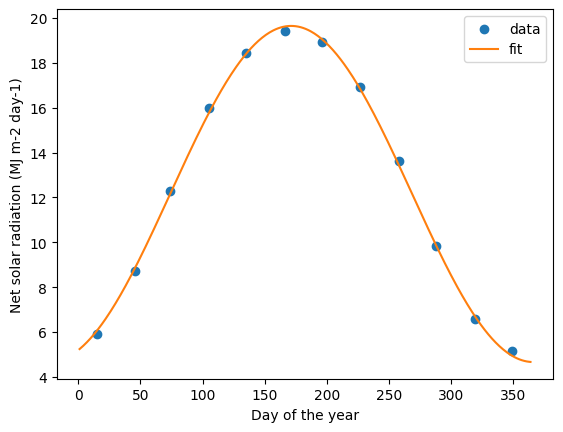

In [8]:
# fit the curve to the solar radiation data and extract the curve parameters
popt, pcov = curve_fit(sine_function, doy15, solar_radiation_data)

# extrapolate radiation over a year
doy365 = np.arange(1, 365, 1)
solar_radiation_fit = sine_function(doy365, *popt)

# plot the solar radiation data and the fitted curve
plt.scatter(doy15, solar_radiation_data, color="tab:blue", label='data')
plt.plot(doy365, solar_radiation_fit, color="tab:orange", label='fit')
plt.xlabel('Day of the year')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.legend()

### Justification for using yearly average temperature

Testing showed, that the difference between using monthly average temperature values or yearly average temperature values is negligible for fitting the sine curve. We decided to use yearly average temperature values to reduce the number of input parameters without losing accuracy.  

**Example:** The following code fits the sine curve using yearly average temperature values and compares to the curve that was fitted using monthly average temperature values.   

In [13]:
# repeat calculations using yearly mean temperatures
tmin_year = np.mean(tmin)
tmax_year = np.mean(tmax)
solar_radiation_yearly = []
for doy in doy15: 
    results = calculateSolarRadiation(doy,lat,tmin,tmax)
    # save dailyNetRad to list
    solar_radiation_yearly.append(results)

# fit the curve to the solar radiation data and extract the curve parameters
popt_yearly, pcov_yearly = curve_fit(sine_function, doy15, solar_radiation_yearly)

# extrapolate radiation over a year
solar_radiation_yearlyfit = sine_function(doy365, *popt_yearly)

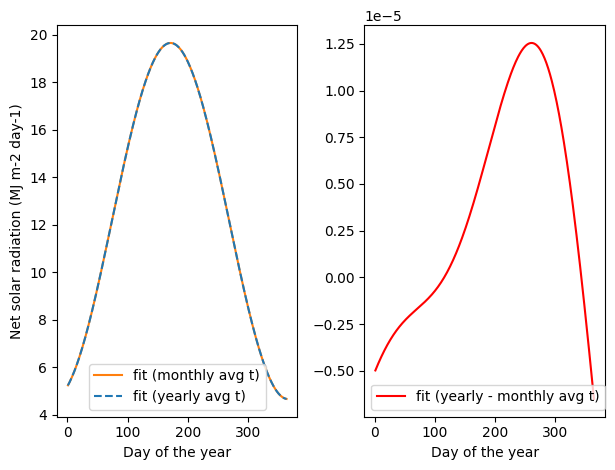

In [14]:
# comparing monthly and yearly solar radiation
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(doy365, solar_radiation_fit, color="tab:orange", label='fit (monthly avg t)')
ax1.plot(doy365, solar_radiation_yearlyfit, linestyle="--", color="tab:blue", label='fit (yearly avg t)')
ax1.set_ylabel('Net solar radiation (MJ m-2 day-1)')
ax1.set_xlabel('Day of the year')
ax1.legend()
solar_radiation_difference = solar_radiation_yearlyfit - solar_radiation_fit
ax2.plot(doy365, solar_radiation_difference, color="red", label=("fit (yearly - monthly avg t)"))
ax2.set_xlabel('Day of the year')
ax2.legend()
plt.tight_layout()

While accuracy of temperature data does impact the solar radiation calculations, the difference between using monthly and yearly average temperature values is around $10^{-5}$ MJ m-2 day-1 and therefore negligible for our use case.  
A quick t-test shows that the difference between both calculations is not significant:  

In [15]:
from scipy.stats import ttest_ind
calculated_data = ttest_ind(solar_radiation_yearly, solar_radiation_data)
alpha = 0.05
if calculated_data[1] < alpha:
    print("Differences between calculated solar radiation data are statistically significant, p = " + str(calculated_data[1]))
else:
    print("Differences between calculated solar radiation data are not statistically significant, p = " + str(calculated_data[1]))

Differences between calculated solar radiation data are not statistically significant, p = 0.9999986708528346


In [16]:
fitted_data = ttest_ind(solar_radiation_yearlyfit, solar_radiation_fit)
if fitted_data[1] < alpha:
    print("Differences between fitted solar radiation data are statistically significant, p = " + str(fitted_data[1]))
else:
    print("Differences between fitted solar radiation data are not statistically significant, p = " + str(fitted_data[1]))

Differences between fitted solar radiation data are not statistically significant, p = 0.9999922821014777


## Variation

Since we are assuming clear sky radiation, variation is assumed to only reduce solar radiation. Since evidence for natural fluctuations in radiation is scarce, variation is assumend to be normally distributed with a mean of half the standard deviation of the solar radiation to be comparable to empiric data ([Barr et al. 2014](https://doi.org/10.1002/2013JD021083)).  
Barr et al. 2014 further suggests that the moving average of solar radiation between may and november is roughly constant. This is implemented in the default variation calculations and equates to a normal distribution with a mean of four times the standard deviation.

## Sensitivity Analysis
### Latitude and day of the year
Using latitude and day of the year (doy) as bifurcation parameter to assess their influence on net solar radiation.  
Allen et al. 1998 additionally suggests limited validity of solar radiation calculations for latitude above 55 degrees (0.9599 rad) North and South.  

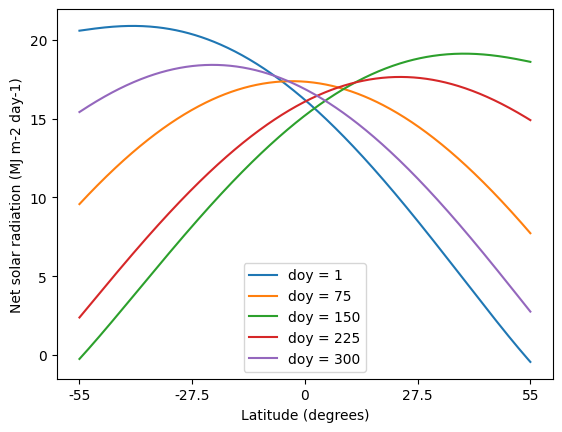

In [155]:
# latitude as bifurcation parameter
doy_range = np.linspace(1, 300, 5)
lat_range = np.linspace(-0.9599, 0.9599, 500)

lat_results = np.zeros((len(lat_range), len(doy_range)))

i = 0
j = 0
for lat in lat_range: 
    j = 0
    for doy in doy_range:
        lat_results[i,j] = calculateSolarRadiation(doy,lat,tmin,tmax)
        j += 1
    i += 1

for id, doy in enumerate(doy_range):
    plt.plot(lat_range, lat_results[:,id], label='doy = ' + str(int(doy)))
# plt.plot(lat_range, lat_results)
plt.xlabel('Latitude (degrees)')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.legend()
plt.xticks([-0.9599, -0.4799, 0, 0.4799, 0.9599], ['-55', '-27.5', '0', '27.5', '55'])
plt.show()

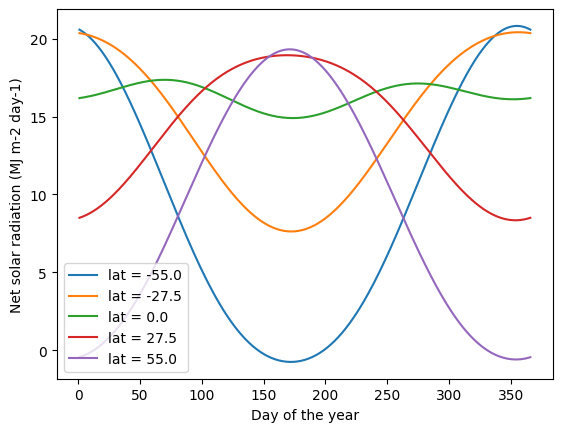

In [165]:
# doy as bifurcation parameter
doy_range = np.linspace(1,366,365)
lat_range = np.linspace(-0.9599, 0.9599, 5)

doy_results = np.zeros((len(doy_range), len(lat_range)))

i = 0
j = 0

for doy in doy_range:
    j = 0
    for lat in lat_range: 
        doy_results[i,j] = calculateSolarRadiation(doy,lat,tmin,tmax)
        j += 1
    i += 1

for id, lat in enumerate(lat_range):
    plt.plot(doy_range, doy_results[:,id], label='lat = ' + str(np.round(np.degrees(lat),2)))
# plt.plot(lat_range, lat_results)
plt.xlabel('Day of the year')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.legend()
plt.show()

In [166]:
# 2d heatmap for latitude and doy
lat_range = np.linspace(-0.9599, 0.9599, 365)
doy_range = np.arange(1, 366, 1)

twod_results = np.zeros((len(lat_range), len(doy_range)))

i = 0
j = 0
for lat in lat_range: 
    j = 0
    for doy in doy_range:
        twod_results[i,j] = calculateSolarRadiation(doy,lat,tmin,tmax)
        j += 1
    i += 1

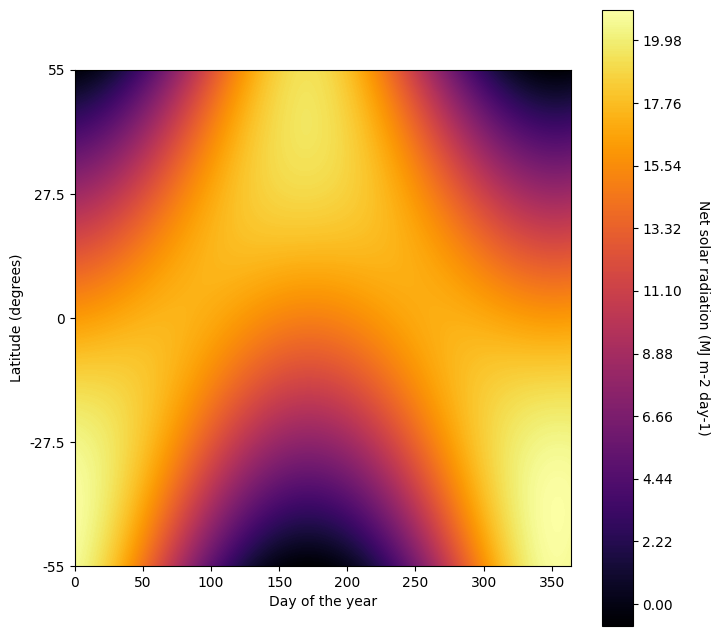

In [189]:
fig, ax = plt.subplots(figsize=(8, 8))
im = plt.contourf(twod_results, cmap='inferno', levels=365)
cbar = fig.colorbar(im)
cbar.set_label('Net solar radiation (MJ m-2 day-1)', rotation=270, labelpad=20)
ax.set_yticks(np.linspace(0, 364, 5))
ax.set_yticklabels(['-55', '-27.5', '0', '27.5', '55'])
plt.xlabel('Day of the year')
plt.ylabel('Latitude (degrees)')
plt.axis('square')
plt.show()

### Temperature
Temperature as bifurcation parameter to assess its influence on net solar radiation.  
Note the notation of the yaxis. The differences in solar radiation are minimal (See [Justification for using yearly average temperature](#Justification-for-using-yearly-average-temperature)).

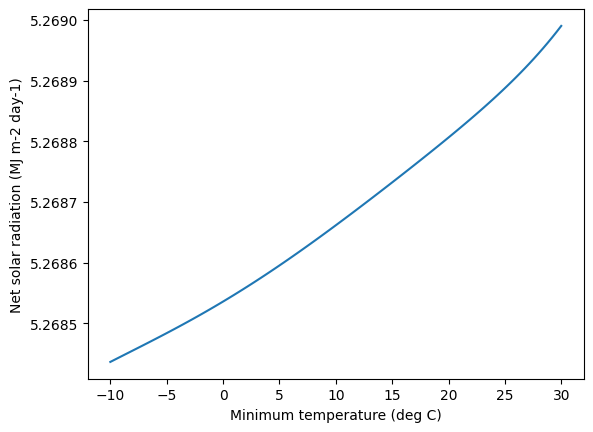

Variance: 2.5316598900494565e-08


In [216]:
# tmin as bifurcation parameter
tmin_range = np.linspace(-10, 30, 100)
doy_range = np.arange(1, 366, 1)
lat = 0.65

tmin_results = []
for tmin in tmin_range:
    tmin_results.append(calculateSolarRadiation(doy,lat,tmin,tmax))

plt.plot(tmin_range, tmin_results)
plt.xlabel('Minimum temperature (deg C)')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.show()
print("Variance: " + str(np.var(tmin_results)))

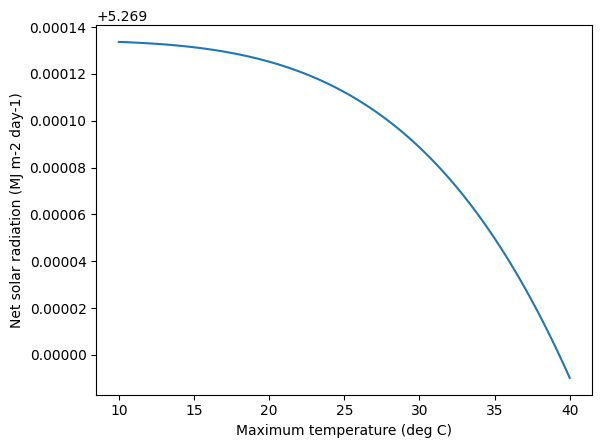

Variance: 1.649858421041292e-09


In [217]:
# tmax as bifurcation parameter
tmax_range = np.linspace(10, 40, 100)
doy_range = np.arange(1, 366, 1)
lat = 0.65

tmax_results = []
for tmax in tmax_range:
    tmax_results.append(calculateSolarRadiation(doy,lat,tmin,tmax))

plt.plot(tmax_range, tmax_results)
plt.xlabel('Maximum temperature (deg C)')
plt.ylabel('Net solar radiation (MJ m-2 day-1)')
plt.show()
print("Variance: " + str(np.var(tmax_results)))